**Нужные библиотеки**

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

warnings.filterwarnings('ignore')

**Константы**

In [2]:
RANDOM_STATE = 180723

#  Прогнозирование оттоков клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.


Данные хранятся в папке /datasets/ в  файлах:
<br><a href=https://code.s3.yandex.net/datasets/contract_new.csv>contract_new.csv</a> — информация о договоре
<br><a href=https://code.s3.yandex.net/datasets/personal_new.csv>personal_new.csv</a> — персональные данные клиента
<br><a href=https://code.s3.yandex.net/datasets/internet_new.csv>internet_new.csv</a> — информация об интернет-услугах
<br><a href=https://code.s3.yandex.net/datasets/phone_new.csv>phone_new.csv</a> — информация об услугах телефонии

## Подготовка данных

**Для начала откроем все файлы
<br>Установим для таблиц индекс - первый столбец, тк он является уникальным**

**Открываемм информацию о договоре**

In [3]:
try:
    df_contract = pd.read_csv('datasets/contract_new.csv', index_col=0)
except:
    df_contract = pd.read_csv('/datasets/contract_new.csv', index_col=0)
print(f'''Размер таблицы "contract_new": 
Строк - {df_contract.shape[0]}
Столбцов - {df_contract.shape[1]}''')
df_contract.head()

Размер таблицы "contract_new": 
Строк - 7043
Столбцов - 7


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


**Открываемм информацию о клиенте**

In [4]:
try:
    df_personal = pd.read_csv('datasets/personal_new.csv', index_col=0)
except:
    df_personal = pd.read_csv('/datasets/personal_new.csv', index_col=0)
print(f'''Размер таблицы "personal_new": 
Строк - {df_personal.shape[0]}
Столбцов - {df_personal.shape[1]}''')
df_personal.head()

Размер таблицы "personal_new": 
Строк - 7043
Столбцов - 4


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


**Открываемм информацию об интернет-услугах**

In [5]:
try:
    df_internet = pd.read_csv('datasets/internet_new.csv', index_col=0)
except:
    df_internet = pd.read_csv('/datasets/internet_new.csv', index_col=0)
print(f'''Размер таблицы "internet_new": 
Строк - {df_internet.shape[0]}
Столбцов - {df_internet.shape[1]}''')
df_internet.head()

Размер таблицы "internet_new": 
Строк - 5517
Столбцов - 7


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


**Открываемм информацию об услугах телефонии**

In [6]:
try:
    df_phone = pd.read_csv('datasets/phone_new.csv', index_col=0)
except:
    df_phone = pd.read_csv('/datasets/phone_new.csv', index_col=0)
print(f'''Размер таблицы "phone_new": 
Строк - {df_phone.shape[0]}
Столбцов - {df_phone.shape[1]}''')
df_phone.head()

Размер таблицы "phone_new": 
Строк - 6361
Столбцов - 1


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


**Соеденим все данные без потерь**

In [7]:
df = df_contract.merge(df_personal, 
                       left_index=True, 
                       right_index=True).merge(df_internet, 
                                               left_index=True, 
                                               right_index=True,
                                               how='left').merge(df_phone, 
                                                                 left_index=True, 
                                                                 right_index=True, 
                                                                 how='left')
print(f'''Размер общей таблицы: 
Строк - {df.shape[0]}
Столбцов - {df.shape[1]}''')
df.head()

Размер общей таблицы: 
Строк - 7043
Столбцов - 19


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


**переименуем колонки под стать**

In [8]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df.columns]
df = df.rename(columns={'streaming_t_v':'streaming_tv'}) # в процессе заметил
df.index.name = 'customer_id'
df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


**Набор признаков:**
<br>*begin_date - дата заключения договора
<br>end_date - дата расторжения договора
<br>type - тип оплаты (месяц/год...)
<br>paperless_billing - электронное выставление счета
<br>payment_method - способ оплаты
<br>monthly_charges - ежемесячная оплата
<br>total_charges - общая сумма расходов
<br>gender - пол
<br>senior_citizen - пожилая возрастная категория
<br>partner	- партнерство
<br>dependents - наличие иждевенциев
<br>internet_service - доступ в интернет
<br>online_security - интернет защита
<br>online_backup - облачное хранилище
<br>device_protection - антивирус
<br>tech_support - тех потдержка
<br>streaming_tv - стриминговое телевидиние
<br>streaming_movies - кинотека
<br>multiple_lines - несколько линий связи*

**Рассмотрим признаки**

In [9]:
def feat_info(feature):
    print('-'*100)
    print(f'{feature.upper()}\n')
    print(f'Первые пять строк:\n{df[feature].head()}')
    print('-'*100)
    print(f'Описательная статистика:\n{df[feature].describe()}')
    print('-'*100)
    print(f'Количество уникальных значений:\n{df[feature].value_counts()}')
    print('-'*100)
    try:
        df[feature].hist()
        plt.show()
    except:
        print('Не удалось построить график')
    print('-'*100)
    print('~'*100)

----------------------------------------------------------------------------------------------------
BEGIN_DATE

Первые пять строк:
customer_id
7590-VHVEG    2020-01-01
5575-GNVDE    2017-04-01
3668-QPYBK    2019-10-01
7795-CFOCW    2016-05-01
9237-HQITU    2019-09-01
Name: begin_date, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count           7043
unique            77
top       2014-02-01
freq             366
Name: begin_date, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: begin_date, Length: 77, dtype: int64
-----------------------------------------------------------------------------------

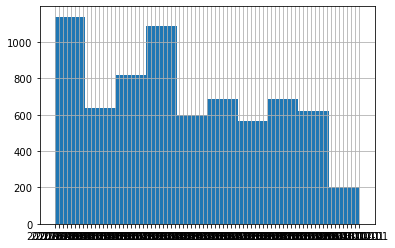

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
END_DATE

Первые пять строк:
customer_id
7590-VHVEG    No
5575-GNVDE    No
3668-QPYBK    No
7795-CFOCW    No
9237-HQITU    No
Name: end_date, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count     7043
unique      67
top         No
freq      5942
Name: end_date, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
20

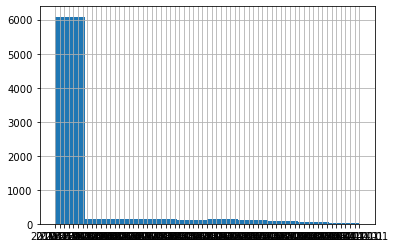

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
TYPE

Первые пять строк:
customer_id
7590-VHVEG    Month-to-month
5575-GNVDE          One year
3668-QPYBK    Month-to-month
7795-CFOCW          One year
9237-HQITU    Month-to-month
Name: type, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count               7043
unique                 3
top       Month-to-month
freq                3875
Name: type, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64
----------

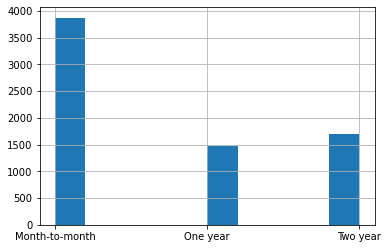

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
PAPERLESS_BILLING

Первые пять строк:
customer_id
7590-VHVEG    Yes
5575-GNVDE     No
3668-QPYBK    Yes
7795-CFOCW     No
9237-HQITU    Yes
Name: paperless_billing, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count     7043
unique       2
top        Yes
freq      4171
Name: paperless_billing, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
Yes    4171
No     2872
Name: paperless_billing, dtype: int64
--------------------------------------------------------------------------------------------------

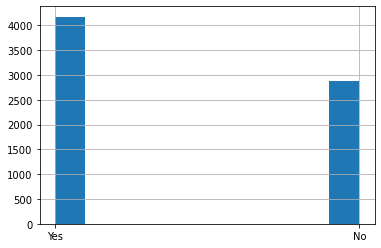

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
PAYMENT_METHOD

Первые пять строк:
customer_id
7590-VHVEG             Electronic check
5575-GNVDE                 Mailed check
3668-QPYBK                 Mailed check
7795-CFOCW    Bank transfer (automatic)
9237-HQITU             Electronic check
Name: payment_method, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count                 7043
unique                   4
top       Electronic check
freq                  2365
Name: payment_method, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
Electronic 

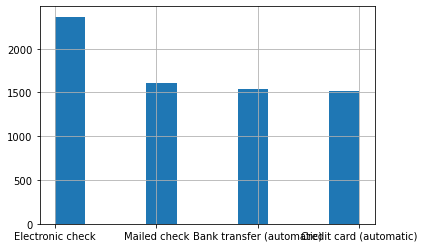

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
MONTHLY_CHARGES

Первые пять строк:
customer_id
7590-VHVEG    29.85
5575-GNVDE    56.95
3668-QPYBK    53.85
7795-CFOCW    42.30
9237-HQITU    70.70
Name: monthly_charges, dtype: float64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
20.05     61
19.85     45
19.95     44
19.90  

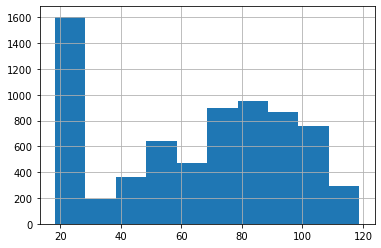

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
TOTAL_CHARGES

Первые пять строк:
customer_id
7590-VHVEG      31.04
5575-GNVDE    2071.84
3668-QPYBK     226.17
7795-CFOCW     1960.6
9237-HQITU      353.5
Name: total_charges, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count     7043
unique    6658
top           
freq        11
Name: total_charges, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
           11
20.45       6
101.0       5
21.53       4
40.1        4
           ..
4357.5      1
3509.55     1
2530.8      1
2599.1      1
7251.82     

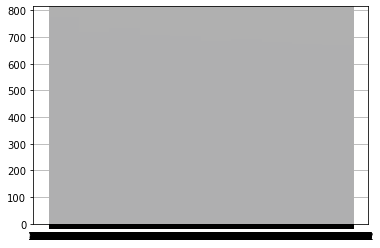

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
GENDER

Первые пять строк:
customer_id
7590-VHVEG    Female
5575-GNVDE      Male
3668-QPYBK      Male
7795-CFOCW      Male
9237-HQITU    Female
Name: gender, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count     7043
unique       2
top       Male
freq      3555
Name: gender, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
Male      3555
Female    3488
Name: gender, dtype: int64
----------------------------------------------------------------------------------------------------


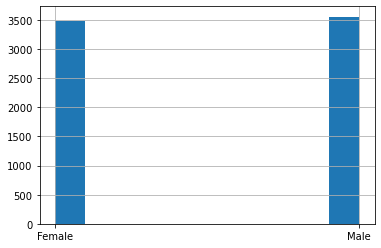

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
SENIOR_CITIZEN

Первые пять строк:
customer_id
7590-VHVEG    0
5575-GNVDE    0
3668-QPYBK    0
7795-CFOCW    0
9237-HQITU    0
Name: senior_citizen, dtype: int64
----------------------------------------------------------------------------------------------------
Описательная статистика:
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: senior_citizen, dtype: float64
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
0    5901
1    1142
Name: senior_citizen, dtype: int64
----------------

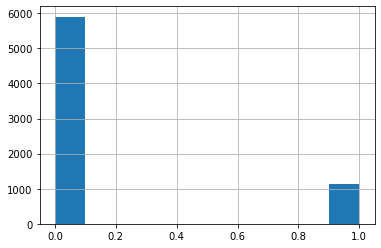

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
PARTNER

Первые пять строк:
customer_id
7590-VHVEG    Yes
5575-GNVDE     No
3668-QPYBK     No
7795-CFOCW     No
9237-HQITU     No
Name: partner, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count     7043
unique       2
top         No
freq      3641
Name: partner, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
No     3641
Yes    3402
Name: partner, dtype: int64
----------------------------------------------------------------------------------------------------


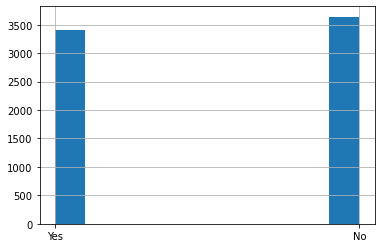

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
DEPENDENTS

Первые пять строк:
customer_id
7590-VHVEG    No
5575-GNVDE    No
3668-QPYBK    No
7795-CFOCW    No
9237-HQITU    No
Name: dependents, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count     7043
unique       2
top         No
freq      4933
Name: dependents, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
No     4933
Yes    2110
Name: dependents, dtype: int64
----------------------------------------------------------------------------------------------------


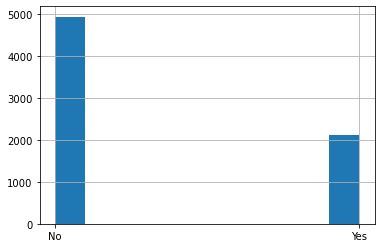

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
INTERNET_SERVICE

Первые пять строк:
customer_id
7590-VHVEG            DSL
5575-GNVDE            DSL
3668-QPYBK            DSL
7795-CFOCW            DSL
9237-HQITU    Fiber optic
Name: internet_service, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count            5517
unique              2
top       Fiber optic
freq             3096
Name: internet_service, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64
------------------

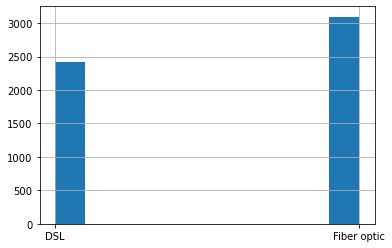

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
ONLINE_SECURITY

Первые пять строк:
customer_id
7590-VHVEG     No
5575-GNVDE    Yes
3668-QPYBK    Yes
7795-CFOCW    Yes
9237-HQITU     No
Name: online_security, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count     5517
unique       2
top         No
freq      3498
Name: online_security, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
No     3498
Yes    2019
Name: online_security, dtype: int64
----------------------------------------------------------------------------------------------------


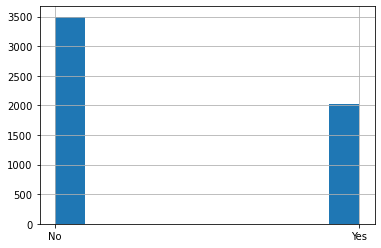

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
ONLINE_BACKUP

Первые пять строк:
customer_id
7590-VHVEG    Yes
5575-GNVDE     No
3668-QPYBK    Yes
7795-CFOCW     No
9237-HQITU     No
Name: online_backup, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count     5517
unique       2
top         No
freq      3088
Name: online_backup, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
No     3088
Yes    2429
Name: online_backup, dtype: int64
----------------------------------------------------------------------------------------------------


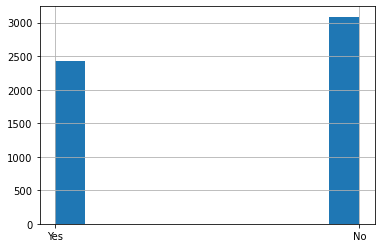

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
DEVICE_PROTECTION

Первые пять строк:
customer_id
7590-VHVEG     No
5575-GNVDE    Yes
3668-QPYBK     No
7795-CFOCW    Yes
9237-HQITU     No
Name: device_protection, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count     5517
unique       2
top         No
freq      3095
Name: device_protection, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
No     3095
Yes    2422
Name: device_protection, dtype: int64
--------------------------------------------------------------------------------------------------

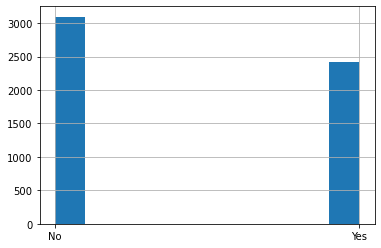

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
TECH_SUPPORT

Первые пять строк:
customer_id
7590-VHVEG     No
5575-GNVDE     No
3668-QPYBK     No
7795-CFOCW    Yes
9237-HQITU     No
Name: tech_support, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count     5517
unique       2
top         No
freq      3473
Name: tech_support, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
No     3473
Yes    2044
Name: tech_support, dtype: int64
----------------------------------------------------------------------------------------------------


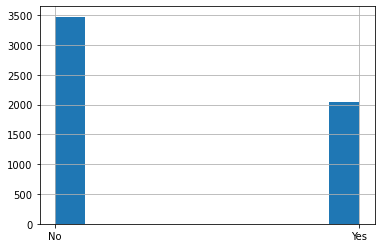

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
STREAMING_TV

Первые пять строк:
customer_id
7590-VHVEG    No
5575-GNVDE    No
3668-QPYBK    No
7795-CFOCW    No
9237-HQITU    No
Name: streaming_tv, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count     5517
unique       2
top         No
freq      2810
Name: streaming_tv, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
No     2810
Yes    2707
Name: streaming_tv, dtype: int64
----------------------------------------------------------------------------------------------------


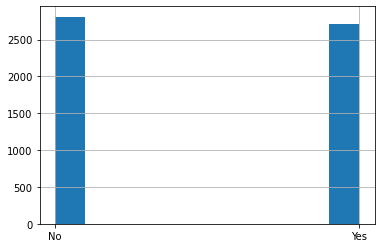

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
STREAMING_MOVIES

Первые пять строк:
customer_id
7590-VHVEG    No
5575-GNVDE    No
3668-QPYBK    No
7795-CFOCW    No
9237-HQITU    No
Name: streaming_movies, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count     5517
unique       2
top         No
freq      2785
Name: streaming_movies, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
No     2785
Yes    2732
Name: streaming_movies, dtype: int64
----------------------------------------------------------------------------------------------------


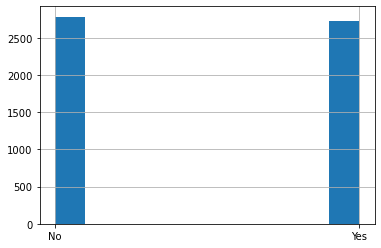

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
----------------------------------------------------------------------------------------------------
MULTIPLE_LINES

Первые пять строк:
customer_id
7590-VHVEG    NaN
5575-GNVDE     No
3668-QPYBK     No
7795-CFOCW    NaN
9237-HQITU     No
Name: multiple_lines, dtype: object
----------------------------------------------------------------------------------------------------
Описательная статистика:
count     6361
unique       2
top         No
freq      3390
Name: multiple_lines, dtype: object
----------------------------------------------------------------------------------------------------
Количество уникальных значений:
No     3390
Yes    2971
Name: multiple_lines, dtype: int64
----------------------------------------------------------------------------------------------------


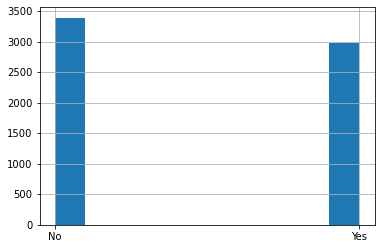

----------------------------------------------------------------------------------------------------
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [10]:
for _ in df.columns:
    feat_info(_)

**По итогу мы имеем:**
<br>*begin_date : нет пропусков, временной 
<br>end_date : нет пропусков, временной
<br>type: нет пропусков, категориальный признак
<br>paperless_billing: нет пропусков, категориальный признак
<br>payment_method: нет пропусков, категориальный признак
<br>monthly_charges: нет пропусков, количественный признак
<br>total_charges: NaN отсутствует, но есть пустые значения строкового типа, количественный признак
<br>gender: нет пропусков, категориальный признак
<br>senior_citizen: нет пропусков, категориальный признак
<br>partner	: нет пропусков, категориальный признак
<br>dependents: нет пропусков, категориальный признак
<br>internet_service: присутсвуют пропуски, категориальный признак
<br>online_security: присутсвуют пропуски, категориальный признак
<br>online_backup: присутсвуют пропуски, категориальный признак
<br>device_protection: присутсвуют пропуски, категориальный признак
<br>tech_support: присутсвуют пропуски, категориальный признак
<br>streaming_t_v: присутсвуют пропуски, категориальный признак
<br>streaming_movies: присутсвуют пропуски, категориальный признак
<br>multiple_lines: присутсвуют пропуски, категориальный признак*

*Так же почти все признаки имеют тип object (для наглядности выведено ниже)
<br>Их тоже надо преобразовать, но сначала посмотрим какие признаки оставить и добавим целевую переменную*

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
 7   gender             7043 non-null   object 
 8   senior_citizen     7043 non-null   int64  
 9   partner            7043 non-null   object 
 10  dependents         7043 non-null   object 
 11  internet_service   5517 non-null   object 
 12  online_security    5517 non-null   object 
 13  online_backup      5517 non-null   object 
 14  device_protection  5517 non-null   object 
 15  tech_support       5517 non-null   object 
 16  streaming_tv  

**Добавим целевую переменную**

In [12]:
df['exited'] = (df['end_date'] != 'No').astype('uint8')
df.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited
customer_id,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0


**Создадим столбец с количеством дней договора абонента и удалим даты
<br>Если он еще активен, то ставим последнюю дату 1 февраля 2020**

In [13]:
df['end_date'] = df['end_date'].replace('No', '2020-02-01')
df[['begin_date','end_date']] = df[['begin_date','end_date']].apply(pd.to_datetime)
df['days'] =(df['end_date'] - df['begin_date']) / np.timedelta64 ( 1 , 'D')

In [14]:
df = df.drop(columns={'begin_date','end_date'})
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited,days
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0,31.0
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036.0
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123.0
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1371.0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153.0


**Заполним пропуски.
<br>Пропуски имеются только в услугах и итоговая сумма, соответсвенно, если у абонента пропуск в услуге, заменим на No, а кто не платил еще, то 0**

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited,days
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.040001,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0,31.0
5575-GNVDE,One year,No,Mailed check,56.95,2071.840088,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036.0
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.169998,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123.0
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.599976,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1371.0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.500000,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153.0


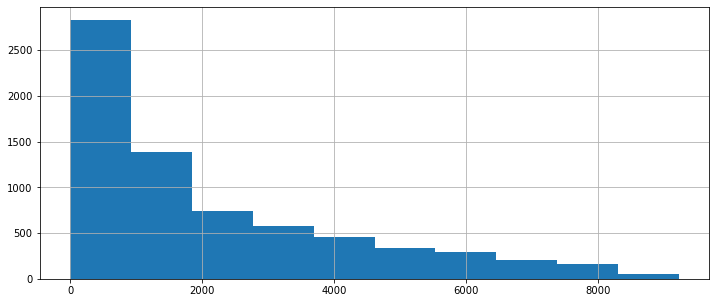

In [15]:
df['total_charges'] = df['total_charges'].replace(' ', '0').astype('float32')
df['total_charges'].hist(figsize=(12,5))
df.head()

In [16]:
df = df.fillna('No')
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited,days
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.040001,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31.0
5575-GNVDE,One year,No,Mailed check,56.95,2071.840088,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036.0
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.169998,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123.0
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.599976,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371.0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.500000,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153.0


**Проверим дубликаты**

In [17]:
df[df.duplicated()]

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited,days
customer_id,,,,,,,,,,,,,,,,,,,
8605-ITULD,Month-to-month,No,Mailed check,19.55,19.549999,Female,0,No,No,No,No,No,No,No,No,No,No,0,31.0
2668-TZSPS,Month-to-month,No,Mailed check,20.45,20.450001,Male,0,No,No,No,No,No,No,No,No,No,No,0,31.0
3892-NXAZG,Two year,Yes,Credit card (automatic),114.05,8211.599609,Male,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0,2191.0
8774-GSBUN,Two year,No,Mailed check,25.40,1828.800049,Male,0,Yes,No,No,No,No,No,No,No,No,Yes,0,2191.0


**Соберем признаки, которые хотем преобразовать**

In [18]:
categorical_features = set()

for _ in df.columns:
    if pd.api.types.is_string_dtype(df[_]):
        categorical_features.add(_)

In [19]:
numeric_features = ['monthly_charges', 'total_charges', 'days']

**Разобьем выборку**

In [20]:
X = df.drop('exited', axis=1)
y = df['exited']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
print(f'Размер обучающей выборки {X_train.shape[0]}')
print(f'Размер тостовой выборки {X_test.shape[0]}')

Размер обучающей выборки 5282
Размер тостовой выборки 1761


**Кодируем категориальные признаки**

In [22]:
categorical_features = list(categorical_features)
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_train[categorical_features])
X_train[categorical_features] = ordinal_encoder.transform(X_train[categorical_features])
X_test[categorical_features] = ordinal_encoder.transform(X_test[categorical_features])

**Масштабируем значения датафрейма**

In [23]:
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [24]:
display(X_train.head())
X_test.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,days
customer_id,,,,,,,,,,,,,,,,,,
2660-EMUBI,0.0,1.0,2.0,1.013454,-0.348087,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,-0.691178
3347-YJZZE,0.0,0.0,1.0,0.505882,0.096255,1.0,0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,-0.022745
0967-BMLBD,1.0,1.0,3.0,-1.494453,-0.899355,0.0,0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.823106
2931-SVLTV,0.0,1.0,1.0,1.504385,1.148500,1.0,0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.468319
4163-KIUHY,0.0,1.0,2.0,-1.308065,-0.582144,1.0,0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.246974


,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,days
customer_id,,,,,,,,,,,,,,,,,,
4877-TSOFF,1.0,1.0,0.0,0.361099,0.900622,0.0,0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.048800
3808-HFKDE,0.0,1.0,2.0,-0.684001,-0.569555,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.422925
7048-GXDAY,0.0,1.0,2.0,1.381236,0.964734,1.0,0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.422877
8375-DKEBR,0.0,1.0,2.0,0.156406,-0.937984,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.226218
1447-GIQMR,0.0,1.0,2.0,0.141428,-0.872683,1.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.136800


**Посмотрим на дисбаланс классов**

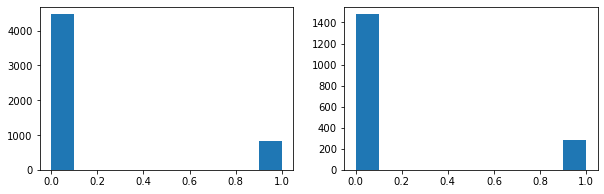

In [25]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].hist(y_train)
ax[1].hist(y_test);

**И вот на выходе мы имеем подготовленные для дальнейшего обучения признаки без пропусков и дубликатов с нормальным распределением данных, а так же ярковыраженным дисбалансом классов**

## Вывод по первому разделу

**1) Данные собраны в один датафрейм без потерь
<br>2) В данных были проблемы с типами данных, которые были преобразованы (прим. total_charges был str)
<br>3) Из-за сборки данных, появились пропуски, которые были заполнены
<br>4) Дубликатов в наборе данных не было выявлено
<br>5) Данные были разбиты для дальнейшего обучения 
<br>6) Категориальные данные были закодированы
<br>7) Весь датасет в дальнейшем был масштабирован
<br>8) Была выделена целевая переменная
<br>9) Данные имеют нормальный вид
<br>10) Выявлена проблема с дисбалансом классов**

# ~

**Вопросы**

1) paperless_billing - это без отправки бумажной квитанции?
<br> 2) begin_date (или любой другой признак с типом datetime) к какому-типу признака относится время? (колич/катег)
<br> 3) Требуются ли какие-то статистические  показатели?

**План работы:**
<br>1) Загрузить и подготовить данные
<br>2) Исследовать данные. (Пропуски/Аномалии/Дубликаты/Распределение)
<br>3) Обучить несколько моделей. Найти лучшую.
<br>4) Провести финальное тестирование
<br>5) Описать выводы по работе

**Наша цель:**
<br>Понять какому клиенту стоит презентовать промо-код или другой бонус, что бы он не ушел 

## Обучение моделей

In [26]:
param_grid = {
      'n_estimators': range(100,1000,100),
      'max_depth': range(1,11)}

**CatBoostClassifier**

In [27]:
%%time
estimator = CatBoostClassifier(random_state=RANDOM_STATE, 
                               verbose = False, 
                               auto_class_weights = 'Balanced')

model_cbc = RandomizedSearchCV(estimator, 
                               param_grid, 
                               verbose = False, 
                               n_jobs=-1,
                               scoring='roc_auc', 
                               random_state=RANDOM_STATE)

model_cbc.fit(X_train, y_train)

parametrs_cbc = model_cbc.best_params_
best_model_cbc = model_cbc.best_estimator_
print(f'ROC-AUC : {model_cbc.best_score_}')
print(f'Параметры : {parametrs_cbc}')

ROC-AUC : 0.8695059919696441
Параметры : {'n_estimators': 900, 'max_depth': 5}
Wall time: 36.8 s


**RandomForestClassifier**

In [28]:
%%time
estimator = RandomForestClassifier(random_state=RANDOM_STATE, 
                                   class_weight = 'balanced')

model_rfc = RandomizedSearchCV(estimator, 
                               param_grid, 
                               verbose = False, 
                               n_jobs=-1,
                               scoring='roc_auc', 
                               random_state=RANDOM_STATE)

model_rfc.fit(X_train, y_train)

parametrs_rfc = model_rfc.best_params_
best_model_rfc = model_rfc.best_estimator_
print(f'ROC-AUC : {model_rfc.best_score_}')
print(f'Параметры : {parametrs_rfc}')

ROC-AUC : 0.8245908164797233
Параметры : {'n_estimators': 700, 'max_depth': 6}
Wall time: 10.7 s


**LGBMClassifier**

In [29]:
%%time
estimator = LGBMClassifier(random_state=RANDOM_STATE, 
                                   class_weight = 'balanced')

model_lgbm = RandomizedSearchCV(estimator, 
                               param_grid, 
                               verbose = False, 
                               n_jobs=-1,
                               scoring='roc_auc', 
                               random_state=RANDOM_STATE)

model_lgbm.fit(X_train, y_train)

parametrs_lgbm = model_lgbm.best_params_
best_model_lgbm = model_lgbm.best_estimator_
print(f'ROC-AUC : {model_lgbm.best_score_}')
print(f'Параметры : {parametrs_lgbm}')

ROC-AUC : 0.8868792532159292
Параметры : {'n_estimators': 800, 'max_depth': 2}
Wall time: 3.72 s


# Тестирование

**Посмотрим на финальные метрики**

In [30]:
predicted_lgbm = best_model_lgbm.predict(X_test)
model_score_roc_lgbm =  roc_auc_score(y_test, best_model_lgbm.predict_proba(X_test)[:,1])                        
print(f"roc_auc = {model_score_roc_lgbm}")

roc_auc = 0.9049612513668995


**Построим ROC кривую**

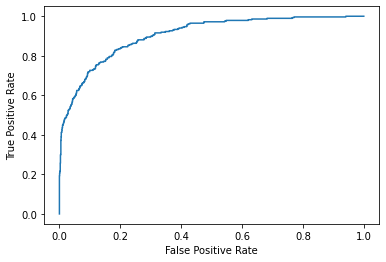

In [31]:
probabilities_test = model_lgbm.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_test) 

plt.figure()
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

**Определим важность признаков**

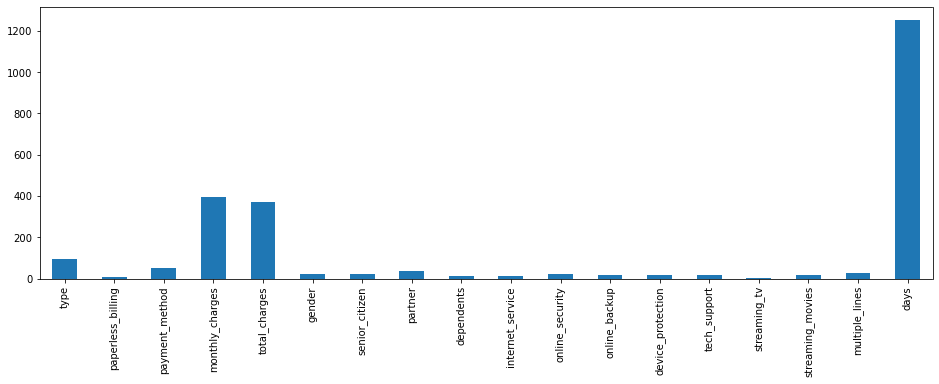

In [32]:
top_params = model_lgbm.best_params_
gbm_model = LGBMClassifier(random_state=RANDOM_STATE, 
                           class_weight = 'balanced',
                           n_estimators=top_params['n_estimators'], 
                           max_depth=top_params["max_depth"])

gbm_model.fit(X_train, y_train)
f_imp = gbm_model.feature_importances_
pd.Series(f_imp, index=X.columns).plot(x=X.columns, kind='bar', figsize=(16,5));

*Можно заметить, что огромный вес среди признаков занимает количество дней "сотрудничества" с оператором, а так конечно же деньги=)*

**Матрица ошибок**

In [33]:
confusion_matrix(y_test, predicted_lgbm, normalize='true')

array([[0.85501355, 0.14498645],
       [0.23157895, 0.76842105]])

*По матрице ошибок можно заметить как раз дисбаланс классов. Достаточно хорошо определяет позитивные сценарии, в отличие от негативных.*

# Вывод по всей работе 

**1) Данные собраны в один датафрейм без потерь
<br> 2) Данные были преобразованы
<br> 3) Были заполнены пропуски
<br> 4) Дубликаты отсутсвуют
<br> 5) Данные были разбиты для обучения
<br> 6) Категориальные данные были закодированы
<br> 7) Весь датасет был масштабирован
<br> 8) Была выделена целевая переменная
<br> 9) Данные имеют нормальный вид
<br> 10) Выявлена проблема с дисбалансом классов
<br> 11) Обучено 3 модели с балансом классов CatBoost, RandomForest и LFBM
<br> 12) Лучшей моделью показала себя LGBMClassifier с параметрами {'n_estimators': 800, 'max_depth': 2}, с метрикой roc_auc = 0.9
<br> 13) Орпеделены наиболее значимые признаки - это количество дней договора, а так же стоимость затрачиваемых на услуги
<br> 14) Построена матрица шибок, которая намекает на дисбаланс классов, и что модели еще стоит обучиться на большем объеме данных**

# Отчет по плану

**Какие пункты плана были выполнены, а какие нет?**

*Перед нами стояла задача определить какие клиенты потенциально могут уйти из компании.
План, который я перед собой поставил, был выполнен полностью.*

**Какие трудности возникли и как вы с ними справились?**

*Особых трудностей по этому проекту на удивление не имелось. Наверно потому что данные были слишком хороши=)*

**Какие ключевые шаги в решении задачи выделили?**

*Ключевыми шагами я считаю:
<br>~ Правильно собранный датасет, с корректными типами данных
<br>~ Избавление от пропусков
<br>~ Разбиение на выборки
<br>~ Обучение моделей с достижением нужной метрики
<br>~ Поиск наиболее весомых признаков
<br>~ И матрица ошибок*

**Какия итоговая модель, какие у нее гиперпаарметры и какое качество?**

*Итоговой моделью стала LGBMClassifier. Переберались такие параметры как глубина равная 2 и число деревьев равное 800. Качество модели оценивали метрикой ROC_AUC равной 0.9*

**Список признаков, используемых для обучения лучшей модели, описание их предобработки**

Список признаков:
<br>*type - тип оплаты
<br>paperless_billing - электронное выставление счета
<br>payment_method - способ оплаты
<br>monthly_charges - ежемесячная оплата
<br>total_charges - общая сумма расходов
<br>gender - пол
<br>senior_citizen  - пенсионер
<br>partner - брак
<br>dependents - дети
<br>internet_service - доступ в интернет
<br>online_security - интернет защита
<br>online_backup - облачное хранилище
<br>device_protection - антивирус
<br>tech_support - тех потдержка
<br>streaming_tv - стриминговое телевидиние
<br>streaming_movies - кинотека
<br>multiple_lines - несколько линий связи
<br>days - количество дней договора*

<br>Действия над ними:
<br> *1) Преобразовали тип данных для total_charges в числовой и зполнили пустые строки нулями
<br> 2) В признаках, обозначающие услугу, заполнили пустоты 'No'
<br> 3) Признак days мы получили из двух удаленных, это начало договора и конец, если конца не было, барли актуальную дату
<br> 4) Разбили на выборки в соотношении 75:25
<br> 5) Потом все категориальные признаки мы закодировали, а количественные масштабтровали*